In [25]:
#imports
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import csv
from itertools import chain

In [26]:
'''from google.colab import drive
drive.mount("/content/gdrive")'''

'from google.colab import drive\ndrive.mount("/content/gdrive")'

In [27]:
#Read in full dataset
data = pd.read_csv('./dataset/sentences.csv',
                            sep='\t', 
                            encoding='utf8', 
                            index_col=0,
                            names=['lang','text'])

#Filter by text length
len_cond = [True if 20<=len(s)<=200 else False for s in data['text']]
data = data[len_cond]

#Filter by text language
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'cmn', 'jpn', 'mar']
data = data[data['lang'].isin(lang)]

#Select 50000 rows for each language
data_trim = pd.DataFrame(columns=['lang','text'])

for l in lang:
    lang_trim = data[data['lang'] ==l].sample(50000,random_state = 100,replace=True)
    data_trim = data_trim.append(lang_trim)

#Create a random train, valid, test split
data_shuffle = data_trim.sample(frac=1)

train = data_shuffle[0:280000]
valid = data_shuffle[280000:360000]
test = data_shuffle[360000:400000]

/var/folders/d5/91jbbmjd3yq8hy37kp93swvh0000gn/T/ipykernel_7912/2012408875.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_trim = data_trim.append(lang_trim)
/var/folders/d5/91jbbmjd3yq8hy37kp93swvh0000gn/T/ipykernel_7912/2012408875.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_trim = data_trim.append(lang_trim)
/var/folders/d5/91jbbmjd3yq8hy37kp93swvh0000gn/T/ipykernel_7912/2012408875.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_trim = data_trim.append(lang_trim)
/var/folders/d5/91jbbmjd3yq8hy37kp93swvh0000gn/T/ipykernel_7912/2012408875.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_trim = 

In [28]:
train.to_csv('./Files/train.csv')
valid.to_csv('./Files/valid.csv')
test.to_csv('./Files/test.csv')

In [29]:
train = pd.read_csv("./Files/train.csv",index_col =0)
valid = pd.read_csv("./Files/valid.csv",index_col =0)
test = pd.read_csv("./Files/test.csv",index_col =0)
print(len(train),len(valid),len(test))
train.head()

280000 80000 40000


,lang,text
7592425,deu,Tom räumte den Tisch ab.
225345,jpn,ケイトは待っている間にボブとメアリーにあった。
8470097,eng,That wasn't the only thing Tom wanted.
165032,jpn,私たちは来週大阪に向かって東京を出発する予定です。
171000,jpn,困り果てて何をしてよいかわからなかった。


In [30]:
def get_trigrams(corpus,n_feat=200):
    """
    Returns a list of the N most common character trigrams from a list of sentences
    params
    ------------
        corpus: list of strings
        n_feat: integer
    """
    
    #fit the n-gram model
    vectorizer = CountVectorizer(analyzer='char',
                            ngram_range=(3, 3)
                            ,max_features=n_feat)
    
    X = vectorizer.fit_transform(corpus)
    
    #Get model feature names
    feature_names = vectorizer.get_feature_names()
    
    return feature_names

In [31]:
#obtain trigrams from each language
features = {}
features_set = set()

for l in lang:
    
    #get corpus filtered by language
    corpus = train[train.lang==l]['text']
    
    #get 200 most frequent trigrams
    trigrams = get_trigrams(corpus)
    
    #add to dict and set
    features[l] = trigrams 
    features_set.update(trigrams)

    
#create vocabulary list using feature set
vocab = dict()
for i,f in enumerate(features_set):
    vocab[f]=i

In [32]:
#train count vectoriser using vocabulary
vectorizer = CountVectorizer(analyzer='char',
                             ngram_range=(3, 3),
                            vocabulary=vocab)

#create feature matrix for training set
corpus = train['text']   
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()

train_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)

In [33]:
#Scale feature matrix 
train_min = train_feat.min()
train_max = train_feat.max()
train_feat = (train_feat - train_min)/(train_max-train_min)

#Add target variable 
train_feat['lang'] = list(train['lang'])

In [34]:
#create feature matrix for validation set
corpus = valid['text']   
X = vectorizer.fit_transform(corpus)

valid_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
valid_feat = (valid_feat - train_min)/(train_max-train_min)
valid_feat['lang'] = list(valid['lang'])

#create feature matrix for test set
corpus = test['text']   
X = vectorizer.fit_transform(corpus)

test_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
test_feat = (test_feat - train_min)/(train_max-train_min)
test_feat['lang'] = list(test['lang'])

In [35]:
train_feat.to_csv('./Feature_Files/train.csv')
valid_feat.to_csv('./Feature_Files/valid.csv')
test_feat.to_csv('./Feature_Files/test.csv')

In [36]:
train_feat = pd.read_csv("./Feature_Files/train.csv",index_col =0)
valid_feat = pd.read_csv("./Feature_Files/valid.csv",index_col =0)
test_feat = pd.read_csv("./Feature_Files/test.csv",index_col =0)
print(len(train_feat),len(valid_feat),len(test_feat))
train_feat.head()

280000 80000 40000


,n m,ばなら,くなっ,uld,ry,a m,tha,ue,ha,we,...,o f,re,るため,因为我,ुमच,it,ois,र आ,ang,lang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,deu
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jpn
2,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,eng
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jpn
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jpn


In [37]:
len(train_feat.columns)

1228

In [38]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#Fit encoder
encoder = LabelEncoder()
encoder.fit(['deu', 'eng', 'fra', 'ita', 'por', 'cmn', 'jpn', 'mar'])

def encode(y):
    """
    Returns a list of one hot encodings 
    
    Params
    ---------
        y: list of language labels
    """
    
    y_encoded = encoder.transform(y)
    y_dummy = np_utils.to_categorical(y_encoded)
    
    return y_dummy

In [39]:
from keras.models import Sequential
from keras.layers import Dense

x = train_feat.drop('lang',axis=1)
y = encode(train_feat['lang'])

x_val = valid_feat.drop('lang',axis=1)
y_val = encode(valid_feat['lang'])

In [40]:
#final model
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l2

#Get training data
x = train_feat.drop('lang',axis=1)
y = encode(train_feat['lang'])

model = Sequential()
model.add(Dense(50, input_dim=len(train_feat.columns)-1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.75))
model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.75))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                61400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
Total params: 61,998
Trainable params: 61,998
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit(x,y,epochs=4,batch_size=100)

Epoch 1/4
2800/2800 [==============================] - 7s 2ms/step - loss: 1.7991 - accuracy: 0.3610
Epoch 2/4
2800/2800 [==============================] - 5s 2ms/step - loss: 1.6213 - accuracy: 0.4191
Epoch 3/4
2800/2800 [==============================] - 4s 2ms/step - loss: 1.5664 - accuracy: 0.4362
Epoch 4/4
2800/2800 [==============================] - 4s 2ms/step - loss: 1.5296 - accuracy: 0.4459


In [43]:
model.save_weights("./Weights/weight.h5")

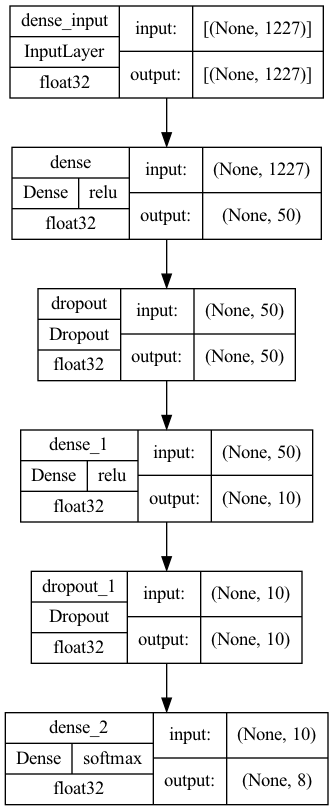

In [44]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    # show_trainable=False,
)

1250/1250 [==============================] - 2s 1ms/step
0.775275


Text(86.25, 0.5, 'Actual')

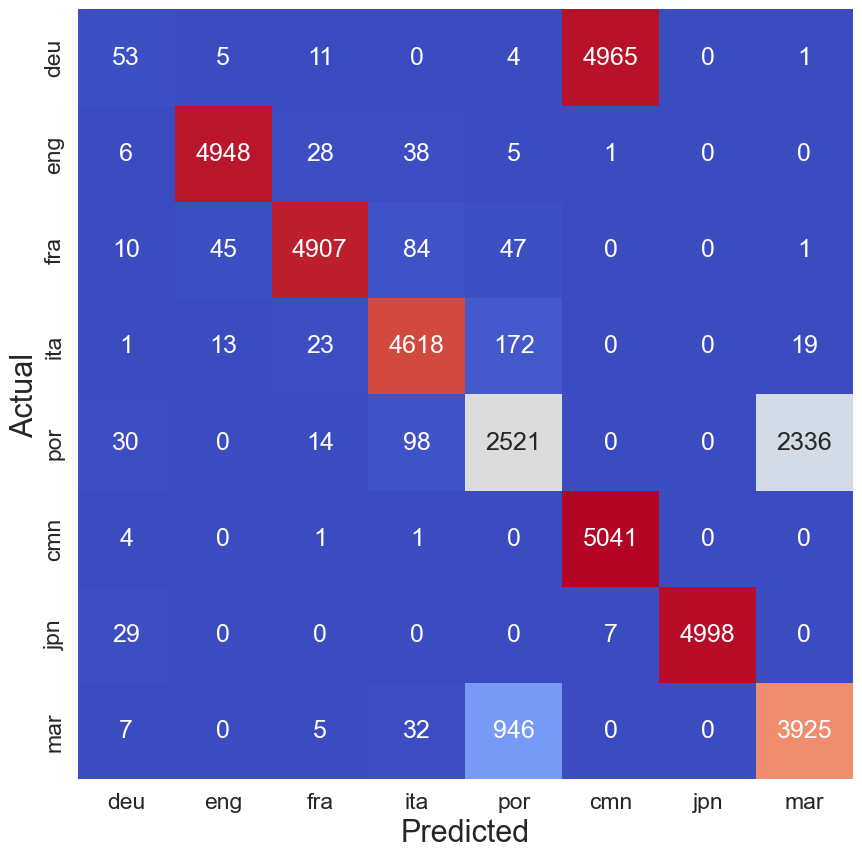

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix

x_test = test_feat.drop('lang',axis=1)
y_test = test_feat['lang']

#Get predictions on test set
labels = model.predict(x_test)
classes_x=np.argmax(labels,axis=1)
predictions = encoder.inverse_transform(classes_x)

accuracy = accuracy_score(y_test,predictions)
print(accuracy)

#Create confusion matrix
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'cmn', 'jpn', 'mar']
conf_matrix = confusion_matrix(y_test,predictions)
conf_matrix_df = pd.DataFrame(conf_matrix,columns=lang,index=lang)

#Plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)
plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)

In [46]:
#converting the sentence to csv file
def String_to_csv(String_text_to_predict):
     utf8_string_text_to_predict=String_text_to_predict.encode("utf-8")


     text_file = open("./Predict_Sentence/text_to_predict.txt", "w")
     n = text_file.write(String_text_to_predict)
     text_file.close()

     with open("./Predict_Sentence/text_to_predict.txt", "r") as fin,\
          open("./Predict_Sentence/text_to_predict.csv", "w") as fout:
          zipped = zip(*(line.rstrip().split() for line in fin))
          fout.write(" ".join(chain(*zipped)))

In [47]:
#create feature matrix for the predicting sentence
def csv_to_feature_matrix():
    csv_text_to_predict=pd.read_csv("./Predict_Sentence/text_to_predict.csv", encoding= 'utf-8')
    corpus = csv_text_to_predict   
    X = vectorizer.fit_transform(corpus)

    text_to_predict_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
    text_to_predict_feat = (text_to_predict_feat - train_min)/(train_max-train_min)
    text_to_predict_feat.to_csv('./Predict_Sentence/text_to_predict_feat.csv')
    text_to_predict_feat = pd.read_csv("./Predict_Sentence/text_to_predict_feat.csv",index_col =0)
    return text_to_predict_feat

In [48]:
#predict language using the trained model
def get_result(text_to_predict_feat):

    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import accuracy_score,confusion_matrix

    x_test = text_to_predict_feat

    #Get predictions on test set
    labels = model.predict(x_test)
    classes_x=np.argmax(labels,axis=1)
    predictions = encoder.inverse_transform(classes_x)

    print(predictions)

In [54]:
def predict_my_sentence(String_text_to_predict):
    String_to_csv(String_text_to_predict)
    get_result(csv_to_feature_matrix())

In [60]:
String_text_to_predict=input("Enter your query :")
predict_my_sentence(String_text_to_predict)

1/1 [==============================] - 0s 21ms/step
['mar']


In [51]:
# Je cherche cette adresse - french
# 不要动 - japanese
# नेहमी आनंदी राहण्याचा प्रयत्न करा - marathi